<h1>Premise Data Science Problem</h1>
<p>The following is work done for the Premise data challenge.</p>
<p>Answers to questions are below. Content is 
ordered as follows:</p>
<ol>
<li>Data Exploration and Setup</li>
<li>Data Analysis and Statistical Modeling Questions</li>
<li>Modeling Questions</li>
</ol>

<h2>Data Exploration and Setup</h2>
<p>First I will load appropriate libraries</p>

In [1]:
%matplotlib inline
import pandas
import pandasql
import json
import re
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import time
import math
import datetime

pandas.set_option('display.max_columns', 100)
pandas.set_option('display.max_rows', 3000)

<p>Load the data file.</p>

In [4]:
filename="premise_GH_food-staples_2015-07-20.csv"
#meals=pandas.read_csv(filename,encoding='ISO-8859-1',header=0,dtype=object)
meals=pandas.read_csv(filename,encoding='ISO-8859-1',header=0)

<p>Add an epoch time stamp for easier manipulation</p>

In [5]:
t_time_epoch=[time.mktime(time.strptime(i.split(' ')[0],'%Y-%m-%d')) for i in meals['t_time'].values]
meals['t_time_epoch'] = pandas.Series(t_time_epoch, index=meals.index)


<p>The time stamps are not always filled in and 
a couple of the create time stamps are from multiple
years ago (which is weird).</p>

In [7]:
print 'the time stamps are between:',min(meals['t_time']),'--',max(meals['t_time'])
print 'the create time stamps are between (some null):',min(meals[meals['t_created'].notnull()]['t_created']),'--',max(meals['t_created'])
print 'the modify time stamps are between:',min(meals['t_modified']),'--',max(meals['t_modified'])
print 'the upload time stamps are between (some null):',min(meals[meals['t_uploaded_lc'].notnull()]['t_uploaded_lc']),'--',max(meals['t_uploaded_lc'])


the time stamps are between: 2014-10-26 14:33:46 -- 2015-07-20 19:01:00.570000
the create time stamps are between (some null): 2012-01-01 00:34:40.859000 -- 2015-07-22 09:14:49.625000
the modify time stamps are between: 2014-10-27 20:01:23.316000 -- 2015-07-20 19:01:00.592000
the upload time stamps are between (some null): 2014-10-26 14:33:46 -- 2015-04-22 12:05:47


In [17]:
print "total number of entries in table", len(meals)
print "total number of unique item identifiers", len(meals['p_item_uuid'].unique())
print 'unique brands',len(meals['p_item_brand_lc'].unique())
print 'unique cities',len(meals['city'].unique())
print 'unique product types',len(meals['p_item_product_lc'].unique())
print 'unique units',len(meals['p_units_lc'].unique())
print 'unique stores',len(meals['l_place_uuid'].unique())
print 'null stores',len(meals[meals['l_place_uuid'].isnull()])

total number of entries in table 248169
total number of unique item identifiers 166
unique brands 85
unique cities 6
unique product types 86
unique units 5
unique stores 6053
null stores 4907


<p>Number of logs per user</p>

In [14]:
q="""
SELECT u_uuid ,COUNT(*) cnt
FROM
(
SELECT DISTINCT p_item_uuid, l_place_uuid , u_uuid  
FROM meals
)
GROUP BY u_uuid
"""
countLogPerUserOrig=pandasql.sqldf(q, locals())

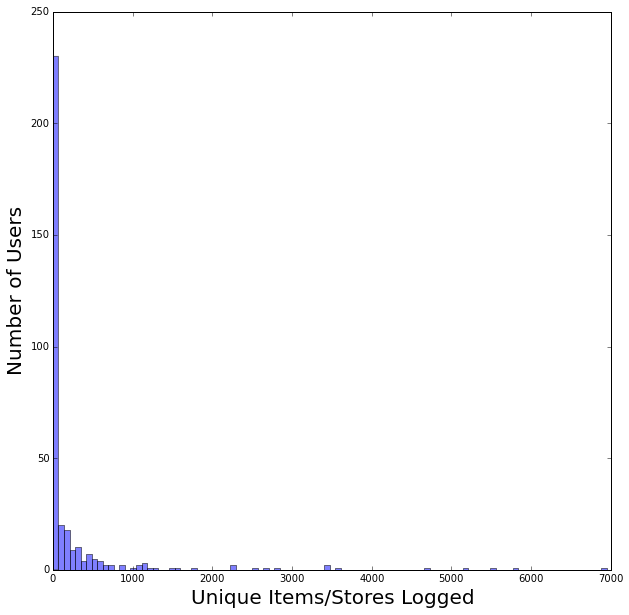

In [16]:
fig = plt.figure(1, figsize=(10,10))
ax = fig.add_subplot(111)
ax.hist(countLogPerUserOrig['cnt'].values, 100,facecolor='blue', alpha=0.5)
ax.set_ylabel('Number of Users',fontsize=20)
ax.set_xlabel('Unique Items/Stores Logged',fontsize=20)
plt.show()

<p>logging over time: there is a weekly periodicity.</p>

In [53]:
t0=1437548400-3600*24*11
t=t0-3600*24*(7*4+1)
print time.mktime(time.strptime('2015-07-22','%Y-%m-%d'))
print time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(1437581689-3600*24*11))
x=meals[meals['t_time_epoch']<t0][meals['t_time_epoch']>=t]['t_time_epoch']
print 'looking at data from ', time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(t)),'to',time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(t0))

1437548400.0
2015-07-11 09:14:49
looking at data from  2015-06-12 00:00:00 to 2015-07-11 00:00:00


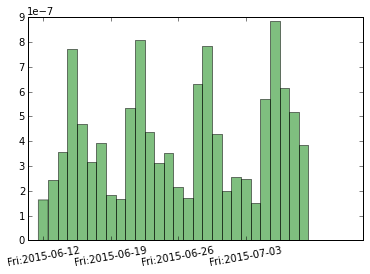

In [60]:
y = [i for i in range(t+3600*12,t0-3600*12,3600*24*7)]
labels = ['Fri:'+time.strftime('%Y-%m-%d', time.localtime(i)) for i in y]
plt.hist(x.values, 7*4, normed=1, facecolor='green', alpha=0.5)
plt.xticks(y, labels, rotation=10)
plt.show()

<h2>Data Analysis and Statistical Modeling Questions</h2>
<ol>
    <li>
    For the data set, identify high price outliers. 
    Explain how you identified these outliers.
    </li>
    <li><ol type="i"><li>For the data set, describe some variables 
    that could be sources of sampling bias when 
    estimating price trends in Ghana. Explain 
    why each of these variables could cause sampling bias.</li>
    <li>Pick one bias (not u_uuid). Write some code 
    that attempts to estimate the potential 
    amount of sample bias caused by this variable, 
    and describe your methodology.</li></ol></li>
</ol>

<h3>For the data set, identify high price outliers. 
Explain how you identified these outliers.</h3>

<p>We can use the information from the normalized_price column to
find the outliers.  We can calculate the mean and standard deviation.
Depending on how harsh we want the cut off to be, items that
are some number of standard deviations higher than the mean
are our outliers.  It also makes sense to do these cut-offs per 
item type (e.g. milk, salt..) and per unit (e.g. g, ml...)</p>

In [66]:
for i in meals['p_item_product_lc'].value_counts().keys():
    for j in meals[meals['p_item_product_lc']==i]['normalized_size_units'].value_counts().keys():
        print 'for',i,'with units',j,'there are a total number of',len(meals[meals['p_item_product_lc']==i][meals['normalized_size_units']==j]['normalized_price'].values)
        mn=np.mean(meals[meals['p_item_product_lc']==i][meals['normalized_size_units']==j]['normalized_price'].values)
        stddev=np.std(meals[meals['p_item_product_lc']==i][meals['normalized_size_units']==j]['normalized_price'].values)
        print 'mean and std:',mn,stddev
        print 'number of items beyond 1 std:',len(meals[meals['p_item_product_lc']==i][meals['normalized_size_units']==j][meals['normalized_price']>mn+stddev])
        print 'number of items beyond 2 std:',len(meals[meals['p_item_product_lc']==i][meals['normalized_size_units']==j][meals['normalized_price']>mn+2*stddev])
        print

 for Fruit juice with units ml there are a total number of 19536
mean and std: 0.00647668765339 0.00274826988333
number of items beyond 1 std: 1773
number of items beyond 2 std: 692

for Fruit juice with units g there are a total number of 43
mean and std: 0.00571627909491 0.000824319356033
number of items beyond 1 std: 1
number of items beyond 2 std: 1

for Fruit juice with units oz there are a total number of 34
mean and std: 0.349808561232 0.0439242243034
number of items beyond 1 std: 2
number of items beyond 2 std: 0

for Rice with units g there are a total number of 12207
mean and std: 0.00730056162928 0.00430029156789
number of items beyond 1 std: 602
number of items beyond 2 std: 562

for Tomato Paste with units g there are a total number of 10951
mean and std: 0.00993063139581 0.00239706637171
number of items beyond 1 std: 1116
number of items beyond 2 std: 242

for Vegetable Oil with units ml there are a total number of 10560
mean and std: 0.00809862088249 0.00227999714027
num

<h3>For the data set, describe some variables that could be sources 
of sampling bias when estimating price trends in Ghana. 
Explain why each of these variables could cause sampling bias.</h3>

<p>The price of goods depends on the brand 
(bargain brand vs. on brand), cost of living of the 
location, seasonality of goods, the type of goods, 
and the amount purchased (bulk vs. personal-size).
'Price trends in Ghana' is a vague enough phrase that 
one would have to define further to meaningfully discuss
the bias in the sample.</p>

<p>One interpretation of this statement is
'the cost of a particular good in Ghana'.  The 
cost is subject to all of the dependencies listed above.
The sample here is biased if the goods logged
do not represent the goods purchased. </p>

<p>Further if we are calculating the literal
price of a given good over time or location, one of the biggest 
biases in the data 
is the lack of an even sample in all locations and time.  The data
is limited to major cities and is not collected evenly 
over all the cities for all of the time period.</p>

<h3>Pick one bias (not u_uuid). Write some code that attempts to 
estimate the potential amount of sample bias caused by this variable, 
and describe your methodology.</h3>

<p>One correction that we can make is to normalize the average price of 
a given item by the population of the city it was calculated for to
find a corrected average for Ghana as a whole.  Since we only have
data for at most 6 cities, this will not fully correct this bias but
it will be a bit of a correction.  I found populations from the following:</p>
<ul>
<li>https://en.wikipedia.org/wiki/Accra</li>
<li>https://en.wikipedia.org/wiki/Tamale,_Ghana</li>
<li>https://en.wikipedia.org/wiki/Kumasi</li>
<li>https://en.wikipedia.org/wiki/Sekondi-Takoradi</li>
<li>https://en.wikipedia.org/wiki/Wa,_Ghana</li>
</ul>
<p>There was only population numbers for a combination of Sekondi and Takoradi
so we have to treat this as a special case.  The code
below corrects for the population for a given item.</p>

In [111]:
def findAvg(item,unit):
    pop={
    'Accra':2291352,
    'Tamale':537986,
    'Kumasi':4000000,
    'Sekondi':445205,
    'Takoradi':445205,
    'ghanawa':102446
    }
    cities=['Accra','Tamale','Kumasi','ghanawa']
    STcities=['Sekondi','Takoradi']
    totPop=0
    normMN=0
    for city in cities:
        if len(meals[meals['city']==city][meals['p_item_product_lc']==item][meals['p_units_lc']==unit])>0:
            totPop+=pop[city]
            normMN+=pop[city]*np.mean(meals[meals['city']==city][meals['p_item_product_lc']==item][meals['p_units_lc']==unit]['normalized_price'].values)
    STnormMN=0
    STtotPop=0
    for city in STcities:
        if len(meals[meals['city']==city][meals['p_item_product_lc']==item][meals['p_units_lc']==unit])>0:
            STtotPop+=len(meals[meals['city']==city][meals['p_item_product_lc']==item][meals['p_units_lc']==unit])
            STnormMN+=len(meals[meals['city']==city][meals['p_item_product_lc']==item][meals['p_units_lc']==unit])*np.mean(meals[meals['city']==city][meals['p_item_product_lc']==item][meals['p_units_lc']==unit]['normalized_price'].values)
    if(len(meals[meals['city']==STcities[0]][meals['p_item_product_lc']==item][meals['p_units_lc']==unit])>0
          or len(meals[meals['city']==STcities[1]][meals['p_item_product_lc']==item][meals['p_units_lc']==unit])>0):
        totPop+=pop[STcities[0]]
        normMN+=float(pop[STcities[0]])*float(STnormMN)/float(STtotPop)
    print 'corrected average price',float(normMN)/float(totPop)
    print 'uncorrected average price',np.mean(meals[meals['p_item_product_lc']==item][meals['p_units_lc']==unit]['normalized_price'].values)

In [113]:
findAvg('Beer','ml')

corrected average price 0.00895689553162
uncorrected average price 0.00876902586562


In [114]:
findAvg('Rice','g')

corrected average price 0.00653818377405
uncorrected average price 0.00730056162928


<h2>Modeling Question</h2>
<ol>
    <li>
    Create a model that predicts price from various metadata.
    </li>
   
        <ol type="i">
            <li>Explain how your model works, and why you chose it.</li>
            <li>Why did you use the metadata you used?</li>
            <li>How can you be sure that you’re not overfitting the model?</li>
        </ol>
    
</ol>

<h3>Explain how your model works, and why you chose it.</h3>

<p>I chose a random forest regressor model from the sklearn library.
I chose it mostly for the speed of the set up.  Another obvious
chose would have been a linear regression model.  The disadvantage of 
the linear regression is that it would require some feature engineering
and feature reduction for a proper answer.  The advantage of the
linear regression is that the coefficients of each feature
contains information about the importance of that feature.
For example, if we had the features (inAccura)(isEgg), (inTamale)(isEgg), and (isEgg)
and we performed LASSO that reduced the coefficients to 
(inAccura)(isEgg) and (inTamale)(isEgg), we could say that the
prices of eggs in Accura and Tamale are
not significantly different and unneeded
in the model.</p>

<p>A random forest model is an ensemble method
constructed from multiple decision trees.  The 
model that I used is a random forest regressor model.
The classical random forest algorithms are classification
algorithms.  We want a continuous value (the price of an item)
therefore the typical random forest method is not appropriate. 
How the random forest regressor works, on the other hand,
is to estimate the continuous values as a series of step functions
as illustrated in the below image.</p>

<img src="https://qph.is.quoracdn.net/main-qimg-411f0501eaf34bfdf80e06552371dd30?convert_to_webp=true">

<h3>Why did you use the metadata you used?</h3>

<p>The inputs that are the most important for predicting 
price of an item are:</p>

<ul>
<li>quantity</li>
<li>brand</li>
<li>city</li>
<li>units</li>
</ul>



<h4>Quantity</h4>
<p>Buying in bulk often is cheaper than buying smaller amounts
of a particular item.  Below are graphs of normalized price
versus quantity for potatoes, plantains, biscuits, and vegetable oil.</p>

In [301]:
p_quantityXp_size=[i*j for i,j in zip(meals['p_quantity'].values,meals['p_size'].values)]
meals['p_quantityXp_size'] = pandas.Series(p_quantityXp_size, index=meals.index)

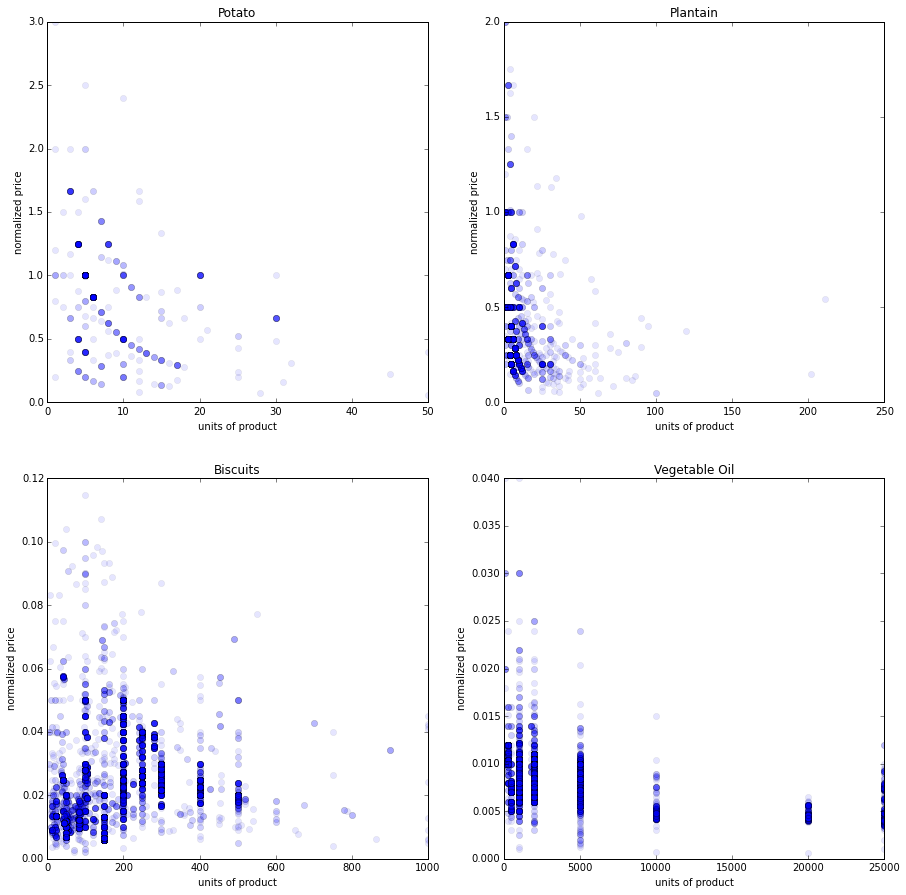

In [157]:
fig = plt.figure(figsize=[15, 15])

x=meals[meals['p_item_product_lc']=='Potato']
ax = plt.subplot(2, 2, 1)
ax.set_title('Potato')
ax.set_xlabel('units of product')
ax.set_ylabel('normalized price')
ax.plot(x['p_quantityXp_size'].values,x['normalized_price'].values,'o',alpha=.1)
x=meals[meals['p_item_product_lc']=='Plantain']
ax = plt.subplot(2, 2, 2)
ax.set_title('Plantain')
ax.set_xlabel('units of product')
ax.set_ylabel('normalized price')
ax.plot(x['p_quantityXp_size'].values,x['normalized_price'].values,'o',alpha=.1)
x=meals[meals['p_item_product_lc']=='Biscuits']
ax = plt.subplot(2, 2, 3)
ax.set_xlim([0,1000])
ax.set_title('Biscuits')
ax.set_xlabel('units of product')
ax.set_ylabel('normalized price')
ax.plot(x['p_quantityXp_size'].values,x['normalized_price'].values,'o',alpha=.1)
x=meals[meals['p_item_product_lc']=='Vegetable Oil']
ax = plt.subplot(2, 2, 4)
ax.set_title('Vegetable Oil')
ax.set_xlabel('units of product')
ax.set_ylabel('normalized price')
ax.plot(x['p_quantityXp_size'].values,x['normalized_price'].values,'o',alpha=.1)
#plt.xlim([-10,1500])
#plt.ylim([0,.025])


<h4>Brand</h4>
<p>Price for a particular type of good
can vary greatly depending on the brand of the good.
Below are prices of two different brands of rice that have a
significantly different price point.</p>

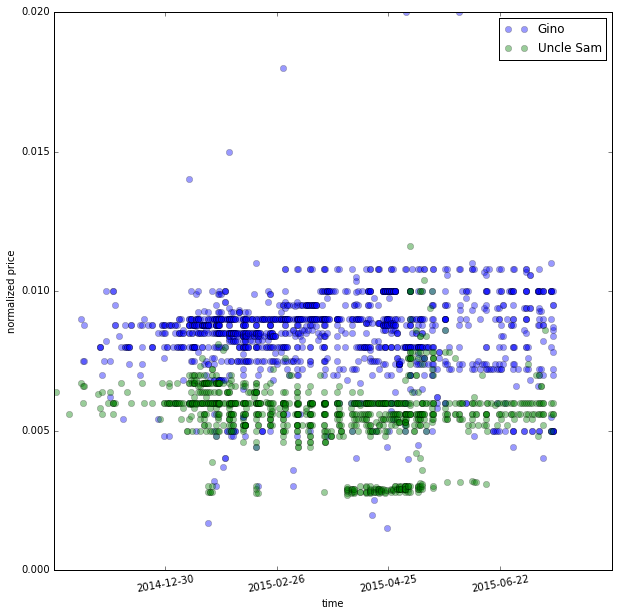

In [196]:
fig = plt.figure(figsize=[10, 10])
ax = plt.subplot(111)

x=meals[meals['p_item_product_lc']=='Rice'][meals['p_item_brand_lc']=='Gino']
ax.plot(x['t_time_epoch'].values,x['normalized_price'].values,'o',alpha=.4)
x=meals[meals['p_item_product_lc']=='Rice'][meals['p_item_brand_lc']=='Uncle Sam']
ax.plot(x['t_time_epoch'].values,x['normalized_price'].values,'o',alpha=.4)
ax.set_xlabel('time')
ax.set_ylabel('normalized price')
y = [1420000000,1425000000,1430000000,1435000000]
labels = [time.strftime('%Y-%m-%d', time.localtime(i)) for i in y]
plt.xticks(y, labels, rotation=10)
ax.legend(['Gino','Uncle Sam'])

<h4>City</h4>
<p>Prices can vary from city to city.  Below is a graph showing the 
price of eggs over time for the city of Accra and Tamale.  The
price of eggs seems to be higher in Accra than Tamale.</p>

([<matplotlib.axis.XTick at 0x11bd07f50>,
 <a list of 4 Text xticklabel objects>)

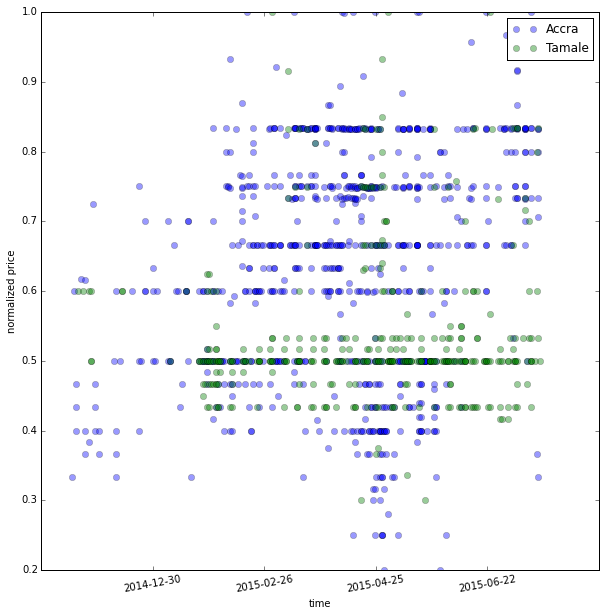

In [198]:
fig = plt.figure(figsize=[10, 10])
ax = plt.subplot(111)

x=meals[meals['p_item_product_lc']=='Chicken Eggs'][meals['city']=='Accra']
ax.plot(x['t_time_epoch'].values,x['normalized_price'].values,'o',alpha=.4)
x=meals[meals['p_item_product_lc']=='Chicken Eggs'][meals['city']=='Tamale']
ax.plot(x['t_time_epoch'].values,x['normalized_price'].values,'o',alpha=.4)
ax.set_ylim([0.2,1])
ax.legend(['Accra','Tamale'])

ax.set_xlabel('time')
ax.set_ylabel('normalized price')
y = [1420000000,1425000000,1430000000,1435000000]
labels = [time.strftime('%Y-%m-%d', time.localtime(i)) for i in y]
plt.xticks(y, labels, rotation=10)


<h4>Units</h4>
<p>Measurements of products in different units often indicates a 
fundamentally different type of product.  For example milk measured
in ml indicates a liquid and in g indicates a powder.  Likewise, 
hot pepper in g could be fresh peppers but also chili powder.  Hot
pepper in pcs. though tends to be fresh peppers.  Additionally, it
is difficult to compare similar products measured in volume and
mass without some sort of look up table.</p>

<p>Below are image of hot pepper measured in grams and pcs.</p>
<img src='https://img.premise.com/0x0/a882a0fe5593485bc65c526f69b1b8fc22cf6ada' style="width: 40%; height: 40%;float: left" >
<img src='https://img.premise.com/0x0/6498b610542c7f2bb97f0be73e4647202820b46d' style="width: 40%; height: 40%;float: right" >

<h3>The Model:</h3>

In [216]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
estimator=RandomForestRegressor()

<p>Creating Features</p>

In [285]:
X=meals[['p_item_product_lc','p_item_brand_lc','city','p_units_lc','p_quantityXp_size']].fillna('nothing').values
y=meals['normalized_price'].values

<h3>How can you be sure that you’re not overfitting the model?</h3>

<p>We can test for overfitting by training on one set of data and
testing the model on another set of data.</p>

In [291]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)
X_train[:, 0] = LabelEncoder().fit_transform(X_train[:,0]) 
X_train[:, 1] = LabelEncoder().fit_transform(X_train[:,1]) 
X_train[:, 2] = LabelEncoder().fit_transform(X_train[:,2]) 
X_train[:, 3] = LabelEncoder().fit_transform(X_train[:,3]) 

clf=estimator.fit(X_train,y_train)

<p>Apply model</p>

In [221]:
y_pred=estimator.predict(X_test)

<p>Plot of predicted price vs. real price.</p>

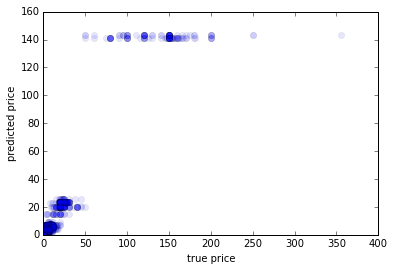

In [269]:
plt.plot(y_test,y_pred,'o',alpha=.1)
plt.xlabel('true price')
plt.ylabel('predicted price')


<p>High priced items seem to be poorly modeled. These items tend to be livestock like chickens and goats.
Such goods do not have a brand and are measured in whole 
pieces.  There is not enough information for the model 
to accurately predict the price of these goods.</p>

In [264]:
print meals[meals['normalized_price']>15]['p_item_product_lc'].value_counts()
print
print meals[meals['normalized_price']>1]['p_units_lc'].value_counts()

Live Chicken (medium size)    839
Goat                          521
Chicken (fresh, whole)        136
Fish (Smoked)                  17
Watermelon                      6
Tilapia, dried (Koobi)          4
Tomato                          1
dtype: int64

pcs.    12384
mudu      174
dtype: int64


<p>Close up of price predicted vs. price actual:</p>

(0, 1)

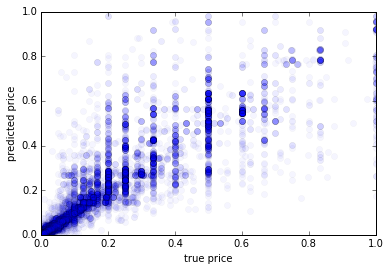

In [279]:
plt.plot(y_test,y_pred,'o',alpha=.04)
plt.xlabel('true price')
plt.ylabel('predicted price')
plt.xlim([0,1])
plt.ylim([0,1])

<p>Smaller items are easier to predict and tend to have more information.</p>

<p>Below is the R-squared:</p>
<img src='http://scikit-learn.org/stable/_images/math/02fd9261058a79736b1df19af192c584f222eb3a.png'>
<p>Essentially, the model is much better than a single value.
The model is fitting well and does not appear to be overfitting</p>

In [272]:
from sklearn.metrics import r2_score
r2_score(y_test, y_pred)  

0.91397585524639191

In [292]:
X_test0=pandas.DataFrame(X_test, columns=['p_item_product_lc','p_item_brand_lc','city','p_units_lc','p_quantityXp_size'])
X_test0['y_test'] = pandas.Series(y_test, index=X_test0.index)
X_test0['y_pred'] = pandas.Series(y_pred, index=X_test0.index)

<p>Error on all predictions</p>

In [281]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test, y_pred)

0.16516561787805453

<p>Error broken down by product type</p>

In [299]:
for i in X_test0['p_item_product_lc'].unique():
    for j in X_test0[X_test0['p_item_product_lc']==i]['p_units_lc'].unique():
        x=X_test0[X_test0['p_item_product_lc']==i][X_test0['p_units_lc']==j]
        print 'mean for',i,'in',j,':',np.mean(x['y_test']),'prediction error:',mean_absolute_error(x['y_test'], x['y_pred'])

mean for Energy Food Drink (packets) in ml : 0.0134023777278 prediction error: 0.000869969972193
mean for Energy Food Drink (packets) in g : 0.029573603858 prediction error: 0.00261336869112
mean for Fruit juice in ml : 0.00649744381745 prediction error: 0.000746866835147
mean for Fruit juice in g : 0.00586666668661 prediction error: 0.000703024488535
mean for Fruit juice in oz : 0.369822487235 prediction error: 0.0228423677074
mean for Plantain in pcs. : 0.393896410108 prediction error: 0.135328483779
mean for Orange in pcs. : 0.24325709422 prediction error: 0.0682286552595
mean for Ice Cream in ml : 0.012353599889 prediction error: 0.00141213671552
mean for Ice Cream in g : 0.0156286652474 prediction error: 0.00144808623413
mean for Rice in g : 0.00715860377872 prediction error: 0.000968153897238
mean for Vegetable Oil in ml : 0.00814507828913 prediction error: 0.000927820298734
mean for Tomato Paste in g : 0.00992291018025 prediction error: 0.00120026005686
mean for Shitto in g : 0.

<h2>Next Steps</h2>
<p>Here are a few things that I would like to do:
<ul>
<li>Compare city locations to lat, long:  There seems to be some difference in the city listed and the latitudes and longitudes give.</li>
<li>Time stamp abnormality: some of the time stamps are from the far past</li>
<li>Use of images: I did not use the images in the analysis but used them to understand the data.  For instance there are several types of Tastic Rice (e.g. sushi rice vs. white rice) that have different price points but with the textual data alone, they are indistinguishable.  If I could do image analysis to signal if the product abnormal, I could explain more of the variance in the data.</li>
</ul>
</p>

In [314]:
def ghana_hexbin(lat, lon, resolution='i', area_thresh=1):
    lon_0, lat_0 = (-1.2,  8.)
    dlon, dlat = (3, 3.5)
    
    not_in_ghana = ((lat < lon_0 - dlat) | 
       (lat > lat_0 + dlat) | 
       (lon < lon_0 - dlon) | 
       (lon > lon_0 + dlon))
    
    print('Number of samples inside (outside) region: %d (%d)' % (np.sum(~not_in_ghana), np.sum(not_in_ghana)))
    
    lat = lat[~not_in_ghana]
    lon = lon[~not_in_ghana]
    
    map = Basemap(projection='merc', resolution=resolution, area_thresh=area_thresh, 
                  llcrnrlon=lon_0 - dlon, llcrnrlat=lat_0 - dlat,
                  urcrnrlon=lon_0 + dlon, urcrnrlat=lat_0 + dlat)
    map.drawcoastlines()
    map.drawcountries()
    x,y = map(lon, lat)
    map.hexbin(x, y, mincnt=1, gridsize=(20, 20), linewidths=0.5, edgecolors='k', 
               cmap='YlOrBr', norm=colors.LogNorm())
    cb = map.colorbar(location='bottom', format='%d', label='# samples')

Number of samples inside (outside) region: 247567 (602)


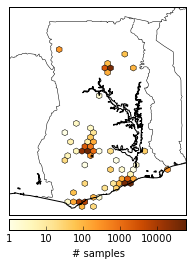

In [315]:
from mpl_toolkits.basemap import Basemap
import matplotlib.colors as colors
ghana_hexbin(meals['g_lat'].values,meals['g_lon'].values)


In [304]:
meals.keys()

Index([u't_time', u'p_item_manufacturer_lc', u'p_item_brand_lc', u'p_item_sub_brand_lc', u'p_item_product_lc', u'p_item_description_lc', u'p_item_uuid', u'packaging', u'p_quantity', u'p_size', u'p_units_lc', u'p_price', u'normalized_price', u'normalized_size_units', u'p_currency', u'g_language', u'city', u'g_country', u'l_place_name', u'l_place_uuid', u'g_lat', u'g_lon', u'g_loc_accuracy', u't_created', u't_modified', u't_uploaded_lc', u'g_timezone', u'g_source', u'thumbnail_0x0', u'thumbnail_300x300', u'u_uuid', u't_time_epoch', u'p_quantityXp_size'], dtype='object')